# Advanced features

This tutorial covers usage of advanced features of ReservoirPy for Reservoir Computing architectures:

- Input-to-readout connections and other complicated connections
- Feedback connections
- Generation and long term forecasting
- Custom weight matrices
- Parallelization
- "Deep" architectures

To go further, the [`examples/`](https://github.com/reservoirpy/reservoirpy/tree/master/examples) folder contains example of complex use cases from the literature.

In [ ]:
%pip install reservoirpy

In [1]:
import reservoirpy as rpy

rpy.set_seed(42)  # make everything reproducible!

In this tutorial, we will be using the same task as introduced in the "Getting started" tutorial: we create 100 samples of a sine wave, and divide these 100 timesteps between a 50 timesteps training timeseries and 50 timesteps testing timeseries. 

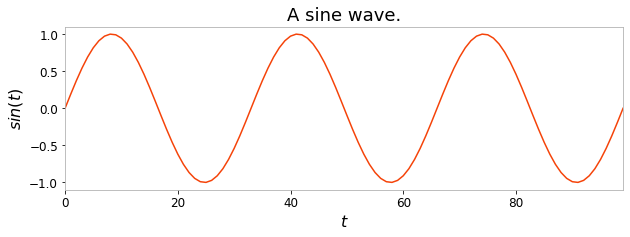

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1, 1)

X_train = X[:50]
Y_train = X[1:51]

plt.figure(figsize=(10, 3))
plt.title("A sine wave.")
plt.ylabel("$sin(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()

## Input-to-readout connections

More advanced ESNs may include direct connections from input to readout. This can be achieved using the `Input` node and advanced features of model creation: connection chaining with the `>>` operator and connection merge using the `&` operator.

In [3]:
from reservoirpy.nodes import Reservoir, Ridge, Input

data = Input()
reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

esn_model = data >> reservoir >> readout & data >> readout

The `&` operator can be used to merge two Model together. 
Here, we first connect the input to the reservoir and the reservoir to the readout. As models are a subclass of nodes, it is also possible to apply the `>>` on models, allowing chaining. When a model is connected to a node, all output nodes of the model are automatically connected to the node. A new model storing all the nodes involved in the process, along with all their connections, is created.

```python
connection_1 = data >> reservoir >> readout

```

Then, we define another model connecting the input to the readout.

```python
connection_2 = data >> readout
```

Finally, we merge all connections into a single model:

```python
esn_model = connection_1 & connection_2
```

A same model can be obtained using another syntax, taking advantage of many-to-one and one-to-many connections. These type of connections are created using iterables of nodes:

In [4]:
esn_model = [data, data >> reservoir] >> readout

In [5]:
esn_model.nodes

[Input, Ridge, Reservoir]

Note that the same can be achieved using the `ESN` class seen previously, using the `input_to_readout` argument:

In [6]:
from reservoirpy import ESN

esn_model2 = ESN(units=100, ridge=1e-7, input_to_readout=True)

## Feedback connections

Feedback connections are another important feature of ESNs. All nodes in ReservoirPy can be connected through feedback connections. Once a feedback connection is established between two nodes, the feedback receiver will receive the state of the feedback sender. When running on a timeseries, **this access will hence allow the receiver to access the output of the sender, with a time delay of one timestep**.

To declare a feedback connection between two nodes, you can use the `<<` operator. This operator will create a model with
a delayed connection from the right operand to the left.

Let's add a feedback connection between our readout and our reservoir.

In [7]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

# Echo State Network with feedback (we can also use ESN(reservoir, readout, feedback=True))
esn_model = reservoir >> readout  # regular feed-forward connection
esn_model &= reservoir << readout  # feedback (delayed) connection

Values output by the readout waiting to be read by the reservoir are stored in a buffer and can be accessed:

In [8]:
esn_model = esn_model.fit(X_train, Y_train)
esn_model(X[0])

print("Stored feedback:", esn_model.feedback_buffers)

Stored feedback: {(Ridge, 1, Reservoir): array([[-1.00263582]])}


Note that the same can be achieved using the `ESN` class seen previously, using the `feedback` argument:

In [9]:
from reservoirpy import ESN

esn_model2 = ESN(units=100, ridge=1e-7, feedback=True)

### Forced feedbacks

Note that adding feedback changes the training procedure: the readout needs the reservoir activity in order to fit its model,
and the reservoir needs the readout output to have a proper activity. We then need **teacher forcing** to obtain convergence: teacher vectors $y$ are used as feedback for the reservoir while readout is not trained.

## Generation and long term forecasting

In this section, we will see how to use ReservoirPy nodes and models to perform long term forecasting or timeseries generation.

We will take a simple ESN as an example:

In [10]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

esn_model = reservoir >> readout

Imagine that we now desire to predict the 100 next steps of the timeseries, given its 10 last steps.

In order to achieve this kind of prediction with an ESN, we first train the model on the simple one-timestep-ahead prediction task defined in the sections above:

In [11]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10)

Now that our ESN is trained on that simple task, the reservoir state is still representative of the dynamics of the input timeseries.

Based on this state, we will now predict the next step in the timeseries. Then, this predicted step will be fed to the ESN again, and so on 100 times, to generate the 100 following timesteps. In other words, the ESN is running over its own predictions.

In [12]:
Y_pred = np.empty((100, 1))
x = Y_train[-1]

for i in range(100):
    x = esn_model(x)
    Y_pred[i] = x

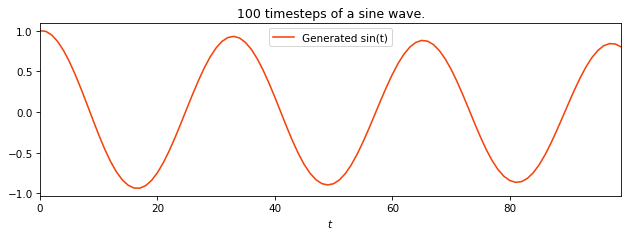

In [13]:
plt.figure(figsize=(10, 3))
plt.title("100 timesteps of a sine wave.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Generated sin(t)")
plt.legend()
plt.show()

The long term forecasting ability of ESNs are one of their most impressive features. You have seen in this section how to perform this kind of generative task using a for-loop and an ESN call method.

## Custom weight matrices

### From reservoirpy.mat_gen module

The `reservoirpy.mat_gen` module contains ready-to-use initializers able to create weights from any `scipy.stats` distribution, along with some more specialized initializations functions.

Below are some examples:

In [15]:
# Random sparse matrix initializer from uniform distribution,
# with spectral radius to 0.9 and connectivity of 0.1.

from reservoirpy.mat_gen import uniform
# Matrix creation can be delayed...
initializer = uniform(sr=0.9, connectivity=0.1)
matrix = initializer(100, 100)

# ...or can be performed right away.
matrix = uniform(100, 100, sr=0.9, connectivity=0.1)

In [16]:
# Dense matrix from Gaussian distribution,
# with mean of 0 and variance of 0.5
from reservoirpy.mat_gen import normal

matrix = normal(50, 100, loc=0, scale=0.5)

# Sparse matrix from uniform distribution in [-0.5, 0.5],
# with connectivity of 0.9 and input_scaling of 0.3.
from reservoirpy.mat_gen import uniform

matrix = uniform(
    200, 60, low=0.5, high=0.5,
    connectivity=0.9, input_scaling=0.3)

# Sparse matrix from a Bernoulli random variable
# giving 1 with probability p and -1 with probability 1-p,
# with p=0.5 (by default) with connectivity of 0.2
# and fixed seed, in Numpy format.
from reservoirpy.mat_gen import bernoulli

matrix = bernoulli(10, 60, connectivity=0.2, sparsity_type="dense")

This functions can be tuned and integrated to any Node accepting initializer functions. In particular, they can be used to tune parameters distribution in a reservoir.

### From Numpy arrays or Scipy sparse matrices

In addition to initializer functions, parameters can be initialized using Numpy arrays or Scipy sparse matrices of correct shape.

In [16]:
from reservoirpy.nodes import Reservoir

W_matrix = np.random.normal(0, 1, size=(100, 100))
bias_vector = np.ones((100, 1))

reservoir = Reservoir(W=W_matrix, bias=bias_vector)

states = reservoir(X[0])

### From custom initializer functions

Readouts and reservoirs hold parameters stored as Numpy array or Scipy sparse matrices. These parameters can be initialized at first run of the node. This initialization is performed by calling initializer functions, which take as parameters the shape of the parameter matrix and return an array or a Scipy matrix. Initializer functions can be passed as parameter to reservoirs or readouts:

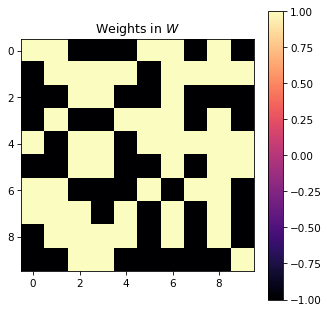

In [18]:
from reservoirpy.nodes import Reservoir

def bernoulli_w(n, m, **kwargs):
    return np.random.choice([-1, 1], size=(n, m))

reservoir = Reservoir(10, W=bernoulli_w)

reservoir(X[0])

plt.figure(figsize=(5, 5))
plt.title("Weights in $W$")
plt.imshow(reservoir.W)
plt.colorbar()
plt.show()

## "Deep" architectures

Nodes can be combined in any way to create deeper structure than just a reservoir and a readout.
Connecting nodes together can be done by chaining the `>>` and the ``&`` operator.

- The `>>` operator allows to compose nodes to form a chain model. Data flows from node to node in the chain.

- The `&` operator allows to merge models together, to create parallel pathways. Merging two chains of nodes will create a new model containing all the nodes in the two chains along with all the connections between them.

Below are examples of so called *deep echo state networks*, from schema to code, illustrating the use of these two operators. More extensive explanations about complex models can be found in the [From Nodes to Models](https://reservoirpy.readthedocs.io/en/latest/user_guide/model.html) documentation.

### Example 1 - Hierarchical ESN

![](./static/deep1.svg)

In [19]:
from reservoirpy.nodes import Reservoir, Ridge


reservoir1 = Reservoir(100, name="res1-1")
reservoir2 = Reservoir(100, name="res2-1")

readout1 = Ridge(ridge=1e-5, name="readout1-1")
readout2 = Ridge(ridge=1e-5, name="readout2-1")

model = reservoir1 >> readout1 >> reservoir2 >> readout2

This model can be trained by explicitly delivering targets to each readout using a dictionary:

In [20]:
model = model.fit(X_train, {"readout1-1": Y_train, "readout2-1": Y_train})

### Example 2 - Deep ESN

![](./static/deep2.svg)

In [21]:
from reservoirpy.nodes import Reservoir, Ridge


reservoir1 = Reservoir(100, name="res1-2")
reservoir2 = Reservoir(100, name="res2-2")
reservoir3 = Reservoir(100, name="res3-2")

readout = Ridge(name="readout-2")

model = reservoir1 >> reservoir2 >> reservoir3 & \
        data >> [reservoir1, reservoir2, reservoir3] >> readout

### Example 3 - Multi-inputs

![](./static/deep3.svg)

In [22]:
from reservoirpy.nodes import Reservoir, Ridge


reservoir1 = Reservoir(100, name="res1-3")
reservoir2 = Reservoir(100, name="res2-3")
reservoir3 = Reservoir(100, name="res3-3")

readout1 = Ridge(name="readout2")
readout2 = Ridge(name="readout1")

model = [reservoir1, reservoir2] >> readout1 & \
        [reservoir2, reservoir3] >> readout2

## Working with incomplete target data

You may encounter situations where you have target data with missing values (NaN). 

This case is covered by the `Model.fit()` and `Node.fit()` methods.

When training or running the model, for the steps where target values are missing, the input values will still be fed to the reservoir - thus updating the reservoir states - but the readout will not be fitted. 

This property can be used to ignore target data that you do not want the readout to be trained on. 

### Example : signal command which corrupted target

In this example, input data is the command for the frequency of a sine wave which will be our target data. In real life, response to command may not be perfect and there could be absurd values. We typically would not want to train our model on the corrupted values. 

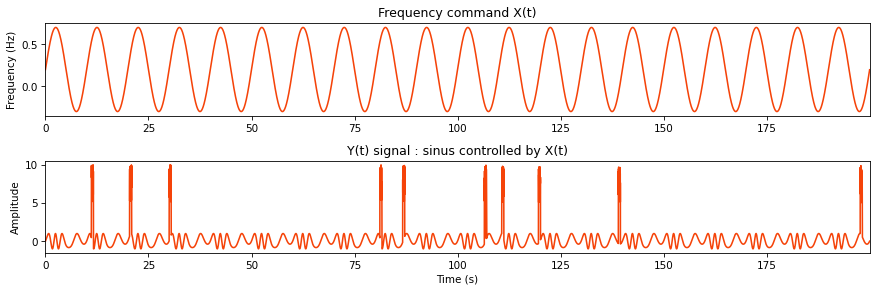

In [23]:
# Parameters
T = 20000  # number of time steps
dt = 0.01  # temporal resolution in seconds
t = np.arange(T) * dt  # time
np.random.seed(42)  # for reproducibility
# frequency command signal X(t) : 
X = 0.5*np.sin(2 * np.pi * 0.1 * t)  + 0.2 

# Y response signal Y(t) 
phase = 2 * np.pi * np.cumsum(X) * dt 
Y = np.sin(phase)
corrupted_indices = np.random.choice(T, size=int(0.0005 * T), replace=False)
corruption_len = 50
for i in corrupted_indices:
    if i < T - corruption_len:
        Y[i:i+corruption_len] = np.random.uniform(5, 10, size=corruption_len)

plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(t, X)
plt.title("Frequency command X(t)")
plt.ylabel("Frequency (Hz)")

plt.subplot(2, 1, 2)
plt.plot(t, Y)
plt.title("Y(t) signal : sinus controlled by X(t)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


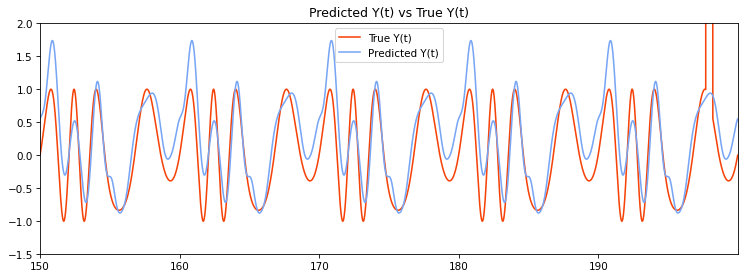

In [24]:
from reservoirpy.nodes import Reservoir, Ridge
train_test_split = int(0.75*T)  # 75% for training, 25% for testing
X_train = X[:train_test_split].reshape(-1, 1)
X_test = X[train_test_split:].reshape(-1, 1)
Y_train = Y[:train_test_split].reshape(-1, 1)
Y_test = Y[train_test_split:].reshape(-1, 1)

reservoir = Reservoir(100, lr=1, sr=0.9)
readout = Ridge(ridge=1e-7)
esn_model = reservoir >> readout
esn_model = esn_model.fit(X_train, Y_train)

pred = esn_model.run(X_test)
plt.figure(figsize=(12, 4))
plt.plot(t[train_test_split:], Y_test, label="True Y(t)")
plt.plot(t[train_test_split:], pred, label="Predicted Y(t)")
plt.legend()
plt.ylim(-1.5, 2)
plt.title("Predicted Y(t) vs True Y(t)")
plt.show()

During the training, corrupted values affect how the ESN learn to predict target values. 

Predicted target data here tends to have higher peaks due to the training on the corrupted target, which we do not want. 

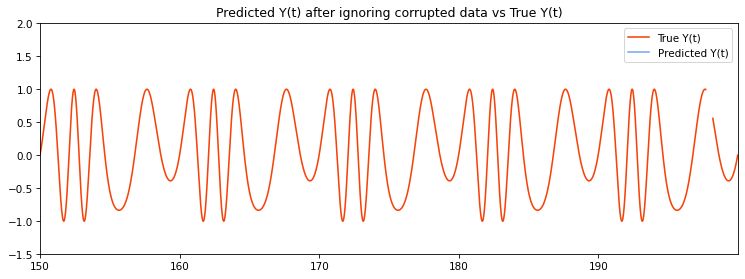

In [25]:
for i in range(len(Y)):
    if Y[i] > 1 or Y[i] < -1:
        Y[i] = np.nan  # ignore corrupted data
Y_train = Y[:train_test_split].reshape(-1, 1)
Y_test = Y[train_test_split:].reshape(-1, 1)
esn_model = esn_model.fit(X_train, Y_train)
pred = esn_model.run(X_test)
plt.figure(figsize=(12, 4))
plt.plot(t[train_test_split:], Y_test, label="True Y(t)")
plt.plot(t[train_test_split:], pred, label="Predicted Y(t)")
plt.legend()
plt.ylim(-1.5, 2)
plt.title("Predicted Y(t) after ignoring corrupted data vs True Y(t)")
plt.show()